In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pylab as pb
import scipy as sp
from tqdm import tqdm

We start from the Stohastic-Volatility Jump-Diffusion Model, which states that: \
$$ dS(t) = S(t)[(r-\lambda \bar{J})dt + \sqrt{V(t)}dW_s(t) + J(Q)dN(t) \text{ (1)} $$
$$ dV(t) = k(\theta - V(t))dt + \sigma \sqrt{V(t)}dW_v(t) \text{ (2)}$$
$ S(t) $- Stock price at time $t$ \
$ r $- risk-free rate \
$ \lambda $ -jump intensity of the standard Poisson jump counting process $N(t)$ \
$ J(Q) $ - Poisson jump-amplitude that satisfies $ Q = ln(J(Q) + 1) $ \
$ V(t) $ - volatility at time $t$ \
$ W_s(t) $ - Brownian Motion of the Stock at time $t$ \
$ k $ - mean-reversion speed \
$ \theta $ - Long-Term volatility \
$ \sigma $ - volatility scale factor \
$ W_v(t) $ - Brownian Motion of the volatility at time $t$

And we later move on to the model for the pricing of the call option.\
To cut it short, here are the functions introduced step by step for the ease of comprehension of the formula \
$$ \delta_{ij} = \text{Kroneker delta that yields 1 if i=j and 0 otherwise} $$
$$ \beta_{j}(r, \tau) = r \tau \delta_{2j} $$
$$ \eta_{j}(\rho, \sigma, y, k) = \rho \sigma (yi + \delta_{1j}) - k $$
$$ \Delta_{j}(\sigma, y, \rho, k) = \sqrt{\eta^2-\sigma^2yi(yi+\delta_{1j})-\delta_{2j}} $$
$$ h_{j}(\tau, \sigma, \rho, y, k) =  \frac{(\eta_{j}^2-\Delta_{j}^2)(\exp(\Delta_{j}\tau)-1)}{\sigma^2(\eta_{j}+\Delta_{j} - (\eta-\Delta_{j})*\exp(\Delta_{j}\tau))}$$
$$ g_{j}(r, \lambda, a, b, y, \tau, k, \theta, \sigma, \rho) = 
((r-\lambda\bar{J})yi-\lambda\bar{J}\delta_{1j} - r\delta_{1j})\tau - \frac{k\theta}{\sigma^2}[2ln(1- (\Delta_{j} + \eta_{j})\frac{1-\exp(-\Delta_{j}\tau)}{2\Delta_{j}}) + (\Delta_{j} + \eta_{j})\tau] + \frac{\exp((yi+\delta_{1j})b) - \exp((yi+\delta_{1j})a)}{(b-a)(yi+\delta_{1j})} - 1 $$
$$ f_{j}(l, v, t, y, T, r, \lambda, a, b, k, \theta, \sigma, \rho) = \exp(h_{j} + g_{j} + yil + \beta_{j}) $$
$$ P_{j}(l, v, t, \kappa, T, r, \lambda, a, b, k, \theta, \sigma, \rho) = 
\frac{1}{2} + \frac{1}{\pi}\int^{+\infty}_{0^+}Re[\frac{\exp(-yi\kappa)*f_{j}}{yi}]dy$$
Finally, the price of the call option is evaluated as: \
$$ \hat{C} =  \exp(l)P_1 - \exp(\kappa-r(T-t))P_2 $$ \
List of variables: \
T - time to maturity \
t - current time \
K - strike price \
S - current stock price \
l = $ln($S$)$ \
kappa = $ln($K$)$ \
v - current volatility \
r - risk-free rate \
$\lambda$ - jump intensity of the standard Poisson jump counting process $N(t)$ \
a, b - parameters for the Q variable defined above \
k - mean-reversion speed \
$\theta$ - LT volatility \
$\sigma$ - volatility scale factor \
$\rho$ - correlation between the two brownian motions used for the simulation of the stock price and volatility

In [2]:
def kron_delta(i, j):
    if i == j:
        return 1
    else:
        return 0

def beta(r, tau, num):
    return r*tau*kron_delta(num, 2)

def eta(rho, sigma, y, num, k):
    return rho*sigma*(1j*y + kron_delta(num, 1)) - k

def Delta(sigma, y, rho, num, k):
    return np.sqrt(eta(rho, sigma, y, num, k)**2 - sigma**2*1j*y*(1j*y+kron_delta(num, 1) - kron_delta(num, 2)))

def h(tau, sigma, rho, y, k, num):
    eta_, Delta_ = eta(rho, sigma, y, num, k), Delta(sigma, y, rho, num, k)
    return (eta_**2- Delta_**2)*(np.exp(Delta_*tau) - 1) / (sigma**2*(eta_ + Delta_ - (eta_ - Delta_)*np.exp(Delta_*tau)))

def g(r, lambda_, a, b, y, tau, k, theta, sigma, rho, num):
    J_, kron_delta_, eta_, Delta_ = (np.exp(b)- np.exp(a))/(b-a) - 1, kron_delta(num, 1), eta(rho, sigma, y, num, k), Delta(sigma, y, rho, num, k) 
    non_int_term = ((r-lambda_*J_)*1j*y-lambda_*J_*kron_delta_ - r*kron_delta_)*tau - k*theta/sigma**2*(2*np.log(1- (Delta_ + eta_)*(1-np.exp(-Delta_*tau))/(2*Delta_)) + (Delta_ + eta_)*tau)
    int_term = (np.exp((1j*y+kron_delta_)*b) - np.exp((1j*y+kron_delta_)*a)) / ((b-a)*(1j*y+kron_delta_)) - 1
    return non_int_term + int_term

def f(l, v, t, y, T, r, lambda_, a, b, k, theta, sigma, rho, num):
    return np.exp(g(r, lambda_, a, b, y, T-t, k, theta, sigma, rho, num) + h(T-t, sigma, rho, y, k, num)*v + 1j*y*l + beta(r, T-t, num))

def P(l, v, t, kappa, T, r, lambda_, a, b, k, theta, sigma, rho, num, begin=1e-9, end=1_000): 
    y = np.linspace(begin, end, int((end-begin))*50) #empirically it was found out that you need to go only up to 1_000 going beyond won't yield meaningful difference, but increasing step size will
    return 1/2 + 1/np.pi*np.trapz(x=y, y=np.real((np.exp(-1j*y*kappa)*f(l, v, t, y, T, r, lambda_, a, b, k, theta, sigma, rho, num)) / (1j*y)))
    
def C_hat(l, v, t, kappa, T, r, lambda_, a, b, k, theta, sigma, rho):
    return np.exp(l)*P(l, v, t, kappa, T, r, lambda_, a, b, k, theta, sigma, rho, 1) - np.exp(kappa-r*(T-t))*P(l, v, t, kappa, T, r, lambda_, a, b, k, theta, sigma, rho, 2)   

In [3]:
#Initialize params used in the paper
T = .1
t = 0
K = 130
S=100
l = np.log(S)
kappa = np.log(K)
v = .012
r=.03
lambda_=64
a=-.028
b=.026
k=.012
theta=.53
sigma=.07
rho=-.622

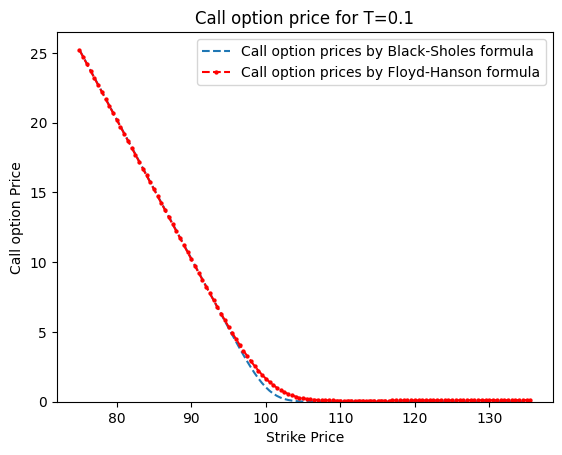

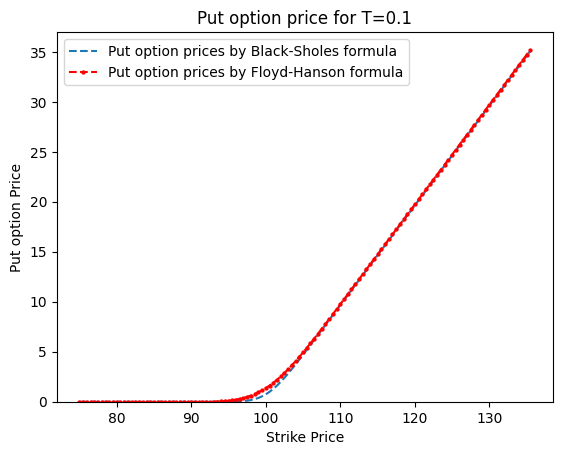

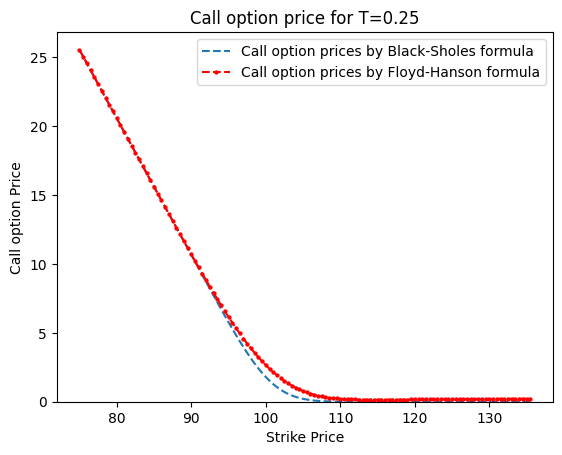

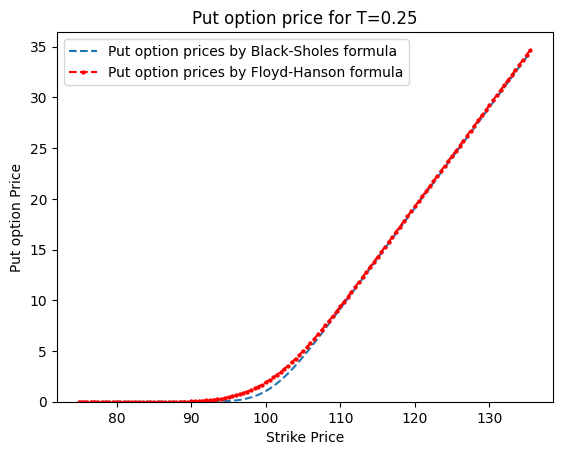

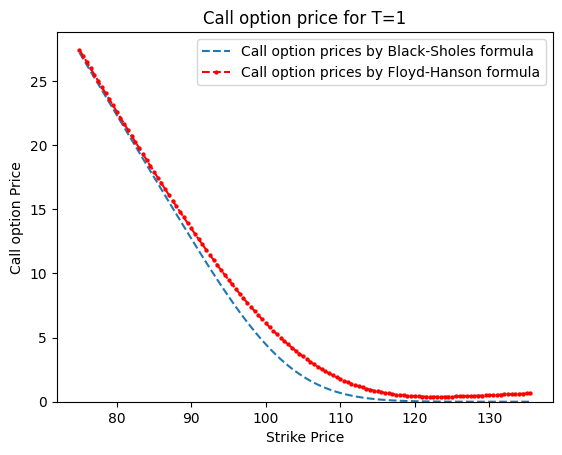

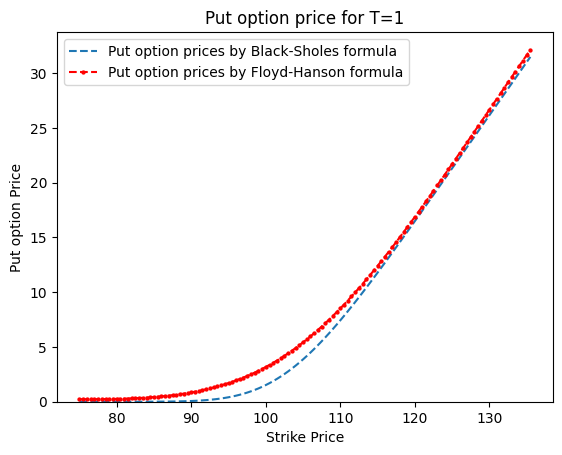

CPU times: total: 17.4 s
Wall time: 17.9 s


<Figure size 640x480 with 0 Axes>

In [4]:
%%time

def BS(S, K, r, sigma, t): #Blakc-Sholes Formula
    d1 = (np.log(S/K)+(r+sigma**2/2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    return S*sp.stats.norm.cdf(d1) - K*np.exp(-r*t)*sp.stats.norm.cdf(d2)

def Put(C, K, S, r, T): #Put option price by put-call parity
    return C + K*np.exp(-r*T) - S


#Replication of the results of the study
K_low = 75
K_up = 135
step = .5

for T in [.1, .25, 1]:
    BS_C_vals = []
    FH_C_vals = []
    for K in np.arange(K_low, K_up + 1, step):
        BS_C_vals.append(BS(S, K, r, sigma, T))
        FH_C_vals.append(C_hat(l, v, t, np.log(K), T, r, lambda_, a, b, k, theta, sigma, rho))
    
    plt.plot(np.arange(K_low, K_up+1, step), BS_C_vals, linestyle='--', label='Call option prices by Black-Sholes formula')
    plt.plot(np.arange(K_low, K_up+1, step), FH_C_vals, linestyle='--', marker= 'o', markersize=2.1, label='Call option prices by Floyd-Hanson formula', color='red')
    plt.title(f"Call option price for T={T}")
    plt.xlabel("Strike Price")
    plt.ylabel("Call option Price")
    plt.ylim(0)
    plt.legend()
    plt.show()
    plt.clf()

    BS_C_vals, FH_C_vals = np.array(BS_C_vals), np.array(FH_C_vals)
    BS_P_vals, FH_P_vals = Put(BS_C_vals, np.arange(K_low, K_up+1, step), S, r, T), Put(FH_C_vals, np.arange(K_low, K_up+1, step), S, r, T)
    
    plt.plot(np.arange(K_low, K_up+1, step), BS_P_vals, linestyle='--', label='Put option prices by Black-Sholes formula')
    plt.plot(np.arange(K_low, K_up+1, step), FH_P_vals, linestyle='--', marker= 'o', markersize=2.1, label='Put option prices by Floyd-Hanson formula', color='red')
    plt.title(f"Put option price for T={T}")
    plt.xlabel("Strike Price")
    plt.ylabel("Put option Price")
    plt.ylim(0)
    plt.legend()
    plt.show()
    plt.clf()